#### Dataset
* https://www.kaggle.com/datasets/lacofloris/type-1-diabetes-blood-glucose-prediction
* Custom log data range: Jan 2 2022 - Apr 25 2022 (a note in author's notebook indicates that 2022/01/09 00:00 is the start date for recording insulin and carbs here, as opposed to using data from glucose meter)
* Fitbit activity data range: Dec 28 2021 - Apr 26 2022
* Glucose meter data range: Dec 21 2021 - Apr 25 2022 (later exports still contain earlier data...)
* Start / end dates may not include full day
* Use range from Jan 9 2022 to Apr 24 2022

##### Some ideas of what models to use
* Time intervals of non-glucose data are irregular / large
* Resampling glucose data so it matches these large intervals would obliterate the kind of granularity of glucose level development required to be forecasted
* Model must accomodate irregular time intervals
    - machine learning models for time series analysis: Long Short-Term Memory (LSTM) and Extreme Gradient Boosting (XGBoost)
    - state space models: regular (frequentist) and Bayesian (BSTS)

In [43]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss

##### Set date range

In [3]:
start_date = pd.to_datetime('2022-01-09')
end_date = pd.to_datetime('2022-04-24')

#### Load Fitbit Data
* Heartrate is the least 'derivative' data. However, during swims Fitbit may not track heartrate. Otherwise, 6 or 7 measurements per minute.
* Active Minutes is the most comprehensive activity measure. Four categories, only daily sums.
* Step Count is not derivative and considered comprehensive together with Active Minutes, but can be misleading if bulk of activity is something other than walking and combined with sedentary job -> leave out for now.
* Sleep data: sleep impacts on stress level, which in turn influences blood glucose -> may add later.

In [4]:
def read_activity(level):
    # get all json files for this activity level
    folder_path = "../data/raw"
    json_files = [file for file in os.listdir(folder_path) if file.endswith(".json") and level in file]

    # read each file into a DataFrame
    activity = []
    for json_file in json_files:
        file_path = os.path.join(folder_path, json_file)
        df = pd.read_json(file_path)
        activity.append(df)

    # combine into a single DataFrame
    df = pd.concat(activity)
    return df.rename(columns={'value': level + '_mins'})

In [5]:
def limit_range(df, datetime_col):
    df[datetime_col] = pd.to_datetime(df[datetime_col])
    return df[(df[datetime_col] >= start_date) & (df[datetime_col] <= end_date)]

In [6]:
# combine all activity levels into a single DataFrame
# note: only works because different types have exactly the same date ranges
df_activity = pd.concat([read_activity(l) for l in ['sedentary', 'lightly', 'moderately', 'very']], axis=1)
# assert(df_activity.iloc[:, 4] == df_activity.iloc[:, 6]).all()

# remove duplicate dateTime columns
df_activity = df_activity.iloc[:, [0, 1, 3, 5, 7]]

# limit to date range
df_activity = limit_range(df_activity, 'dateTime')

df_activity.head()

,dateTime,sedentary_mins,lightly_mins,moderately_mins,very_mins
12,2022-01-09,591,251,21,24
13,2022-01-10,689,283,18,21
14,2022-01-11,635,228,8,12
15,2022-01-12,577,350,27,32
16,2022-01-13,698,251,16,23


In [7]:
# TODO: load heartrate

#### Load Glucose Monitor Data

In [8]:
# TODO: factor both reader methods into one
def read_glucose():
  # get all csv files with 'export' in name
    folder_path = "../data/raw"
    csv_files = [file for file in os.listdir(folder_path) if file.endswith(".csv") and 'export' in file]

    # read each file into a DataFrame
    glucose = []
    for json_file in csv_files:
        file_path = os.path.join(folder_path, json_file)
        # limit to columns containing variables with clear meaning that are not covered in other files; historic: 15 min ave.
        df = pd.read_csv(file_path, sep='\t', usecols=['Time', 'Historic Glucose (mmol/L)', 'Scan Glucose (mmol/L)', 'Strip Glucose (mmol/L)'])
        glucose.append(df)

    # combine into a single DataFrame
    return pd.concat(glucose)

In [9]:
df_glucose = read_glucose()

# shorten and unify column names
df_glucose.rename(columns= {'Time': 'dateTime', 'Historic Glucose (mmol/L)': 'hist_gluc', 'Scan Glucose (mmol/L)': 'scan_gluc', 'Strip Glucose (mmol/L)': 'strip_gluc'}, inplace=True)

# limit to date range
df_glucose = limit_range(df_glucose, 'dateTime')

# drop rows that don't have any glucose data
df_glucose.dropna(how='all', subset=['hist_gluc', 'scan_gluc', 'strip_gluc'], inplace=True)

# drop rows that are exact duplicates
df_glucose.drop_duplicates(keep='first', inplace=True)

# check for dateTime duplicate entries
print("dateTime duplicates:\n", df_glucose.duplicated(subset=['dateTime'], keep=False).value_counts())

df_glucose.head()

dateTime duplicates:
 False    14469
True       710
Name: count, dtype: int64


,dateTime,hist_gluc,scan_gluc,strip_gluc
1253,2022-01-09 00:26:00,NaN,8.2,NaN
1254,2022-01-09 00:34:00,NaN,8.3,NaN
1255,2022-01-09 00:50:00,NaN,8.6,NaN
1256,2022-01-09 01:02:00,NaN,10.2,NaN
1257,2022-01-09 01:08:00,NaN,9.9,NaN


In [10]:
# check how much data each column has
df_glucose.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15179 entries, 1253 to 5470
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   dateTime    15179 non-null  datetime64[ns]
 1   hist_gluc   9789 non-null   float64       
 2   scan_gluc   5340 non-null   float64       
 3   strip_gluc  50 non-null     float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 592.9 KB


In [11]:
# remove column with few values
df_glucose.drop(columns=['strip_gluc'], inplace=True)

# drop rows that are left with all NaN
df_glucose.dropna(how='all', subset=['hist_gluc', 'scan_gluc'], inplace=True)

# check for dateTime duplicates
print("dateTime duplicates:\n", df_glucose.duplicated(subset=['dateTime'], keep=False).value_counts())

dateTime duplicates:
 False    14429
True       700
Name: count, dtype: int64


In [12]:
# take a look at duplicte dateTime
df_mask = df_glucose.duplicated(subset=['dateTime'], keep=False)
df_dups = df_glucose[df_mask].sort_values(by='dateTime')
print('unique dateTime dups:', df_dups.dateTime.nunique())
df_dups.head(10)

unique dateTime dups: 350


,dateTime,hist_gluc,scan_gluc
1253,2022-01-09 00:26:00,NaN,8.2
10794,2022-01-09 00:26:00,7.9,NaN
1270,2022-01-09 12:13:00,NaN,8.4
10841,2022-01-09 12:13:00,8.3,NaN
1305,2022-01-09 20:28:00,NaN,7.6
10874,2022-01-09 20:28:00,7.5,NaN
1326,2022-01-10 01:28:00,NaN,9.8
10894,2022-01-10 01:28:00,9.9,NaN
1719,2022-01-10 13:47:00,8.2,NaN
1342,2022-01-10 13:47:00,NaN,8.4


In [13]:
# every duplicate date occurs exactly twice: Group by 'datetime' and collate
df_glucose = df_glucose.groupby(['dateTime'],as_index=False).first()

# check for dateTime duplicates
print("dateTime duplicates:\n", df_glucose.duplicated(subset=['dateTime']).value_counts())

dateTime duplicates:
 False    14779
Name: count, dtype: int64


In [14]:
df_glucose.set_index('dateTime', inplace=True)
df_glucose.head()

,hist_gluc,scan_gluc
dateTime,,
2022-01-09 00:11:00,7.4,NaN
2022-01-09 00:26:00,7.9,8.2
2022-01-09 00:34:00,NaN,8.3
2022-01-09 00:41:00,8.5,NaN
2022-01-09 00:50:00,NaN,8.6


#### Load Custom Log Data

In [15]:
# load only columns considered relevant by author of data
df_insu_carbs = pd.read_csv('../data/raw/custom_log_2022_01_09-2022_04_25.csv', usecols=['Date', 'Time', 'Tags', 'Basal Injection Units', 'Insulin (Meal)', 'Insulin (Correction)', 'Meal Carbohydrates (Grams, Factor 1)', 'Meal Descriptions', 'Food type'])

# shorten column names
df_insu_carbs.rename(columns={'Basal Injection Units': 'basal_insu', 'Insulin (Meal)': 'meal_insu', 'Insulin (Correction)': 'corr_insu', 'Meal Carbohydrates (Grams, Factor 1)': 'carb_grams', 'Meal Descriptions': 'glyc_index', 'Food type': 'meal_type'}, inplace=True)

# combine meal and 'correction' insulin into one column
df_insu_carbs["rapid_insu"] = df_insu_carbs[["meal_insu", "corr_insu"]].apply(
        lambda x: x["corr_insu"] if np.isnan(x["meal_insu"]) else x["meal_insu"], axis=1
    )

# combine Date and Time into one column, sort 
df_insu_carbs["dateTime"] = pd.to_datetime(df_insu_carbs["Date"] + " " + df_insu_carbs["Time"], format="%b %d, %Y %I:%M:%S %p")
df_insu_carbs.sort_values(by='dateTime', inplace=True)

# drop original columns
df_insu_carbs.drop(columns=['meal_insu', 'corr_insu', 'Date', 'Time'], inplace=True)

# re-order columns
order = ['dateTime', 'basal_insu', 'rapid_insu', 'carb_grams', 'glyc_index', 'meal_type', 'Tags']
df_insu_carbs = df_insu_carbs.reindex(columns=order)

df_insu_carbs.head()

,dateTime,basal_insu,rapid_insu,carb_grams,glyc_index,meal_type,Tags
1786,2022-01-02 14:58:24,NaN,NaN,10.0,NaN,Sweets & snacks,Hypo feeling
1785,2022-01-09 12:11:29,NaN,8.0,40.0,Medium,NaN,Lunch
1784,2022-01-09 12:31:29,NaN,NaN,9.0,Very High,Sweets & snacks,Correction
1783,2022-01-09 15:41:39,NaN,NaN,11.0,Medium,NaN,NaN
1782,2022-01-09 16:22:41,NaN,1.0,NaN,NaN,NaN,NaN


#### EDA

##### Glucose over entire date range

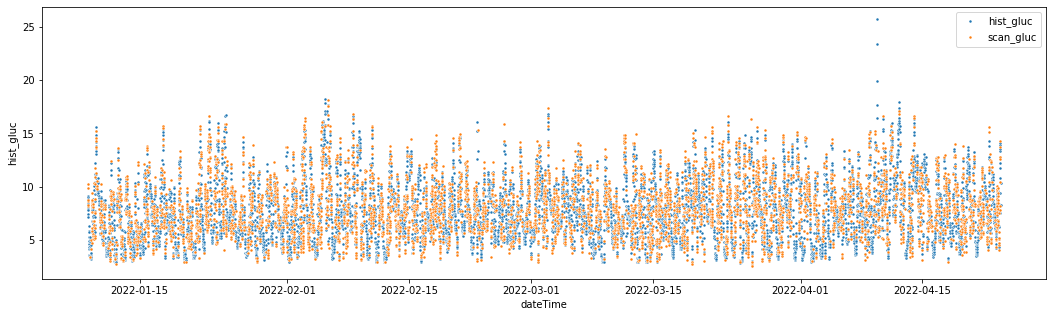

In [16]:
plt.figure(figsize=(18, 5))
sns.scatterplot(x='dateTime', y='hist_gluc', data=df_glucose, label='hist_gluc', marker='.');
sns.scatterplot(x='dateTime', y='scan_gluc', data=df_glucose, label='scan_gluc', marker='.');

##### Zoom in to see if hist_gluc and scan_gluc can be combined

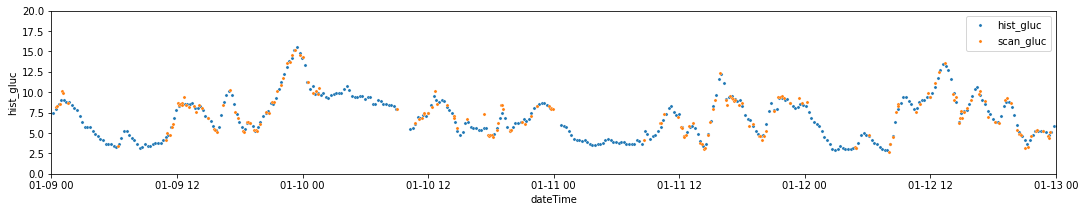

In [17]:
plt.figure(figsize=(18, 3))
ax = sns.scatterplot(data=df_glucose, x='dateTime', y='hist_gluc', label='hist_gluc', s=10)
sns.scatterplot(data=df_glucose, x='dateTime', y='scan_gluc', label='scan_gluc', s=10)
ax.set_xlim(start_date, pd.to_datetime('2022-01-13'))
ax.set_ylim(0,20)
plt.show()

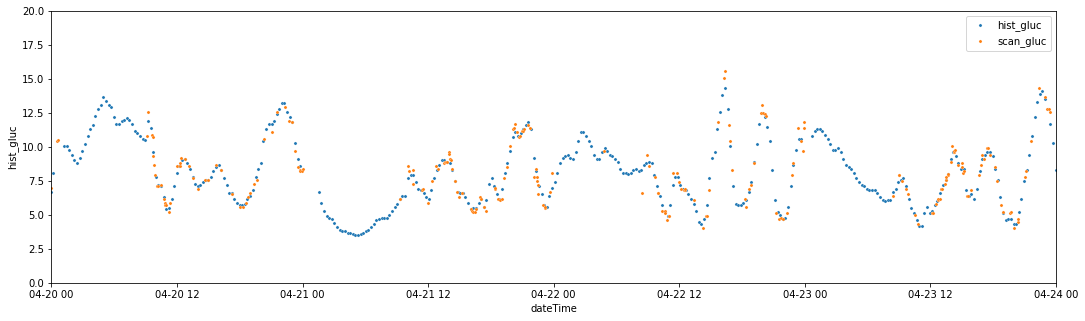

In [18]:
plt.figure(figsize=(18, 5))
ax = sns.scatterplot(data=df_glucose, x='dateTime', y='hist_gluc', label='hist_gluc', s=10)
sns.scatterplot(data=df_glucose, x='dateTime', y='scan_gluc', label='scan_gluc', s=10)
ax.set_xlim(pd.to_datetime('2022-04-20'), end_date)
ax.set_ylim(0,20)
plt.show()

##### Combine glucose data
Data points from glucose measured by a single scan match those of averaged glucose (over 15 minutes according to author). Combine hist_gluc and scan_gluc into one column, using hist_gluc if both are available for the same dateTime.

In [19]:
# combine hist and scan glucose, using hist if both exist
df_glucose['comb_gluc'] = df_glucose['hist_gluc'].combine_first(df_glucose['scan_gluc'])
df_glucose.head()

,hist_gluc,scan_gluc,comb_gluc
dateTime,,,
2022-01-09 00:11:00,7.4,NaN,7.4
2022-01-09 00:26:00,7.9,8.2,7.9
2022-01-09 00:34:00,NaN,8.3,8.3
2022-01-09 00:41:00,8.5,NaN,8.5
2022-01-09 00:50:00,NaN,8.6,8.6


##### Find the best re-sample rate

maximum time gap between two glucose measurements: 0 days 02:52:00
count                        14778
mean     0 days 00:10:13.832724319
std      0 days 00:06:23.751098891
min                0 days 00:01:00
25%                0 days 00:05:00
50%                0 days 00:11:00
75%                0 days 00:15:00
max                0 days 02:52:00
Name: dateTime, dtype: object


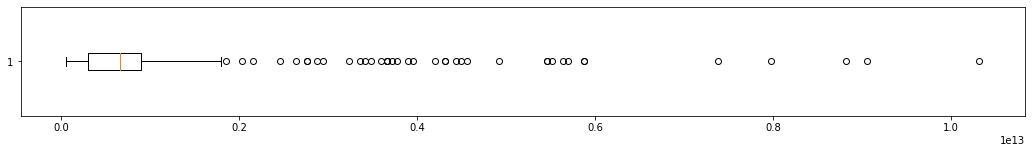

In [20]:
# find biggest gap
max_gap = df_glucose.index.to_series().diff().max()
print('maximum time gap between two glucose measurements:', max_gap)
time_intervals = df_glucose.index.to_series().diff().dropna()
# get stats on gaps
print(time_intervals.describe())
# make box plot of all gap times
plt.figure(figsize=(18, 2))
plt.boxplot(time_intervals, vert=False, showfliers=True)
plt.show()

Note: extreme outliers not included in boxplot, despite showfliers=True.

In [21]:
# use try & error (re-run cell) to find a good cutoff that leaves sample rate less than half an hour
percentile_gap = time_intervals.quantile(0.996)
print("99.6 th percentile of time_intervals:", percentile_gap)

99.6 th percentile of time_intervals: 0 days 00:19:00


Visualize remaining gaps with sample rate

In [22]:
def scatter_patch(df, gap, date_start, date_end, patch=True):
    # Create the scatter plot with highlighted background for areas outside the xth percentile
    plt.scatter(df.index, df['comb_gluc'], marker='.', s=10);

    # Initialize a variable to count the number of patches
    patch_count = 0

    # Draw highlighted areas for intervals outside xth percentile within the specified date range
    if (patch):
        for i in range(1, len(df.index)):
            if (time_intervals[i-1] > gap) and (date_start <= df.index[i-1] <= date_end):
                rect = patches.Rectangle((df.index[i-1], plt.ylim()[0]), time_intervals[i-1], plt.ylim()[1]-plt.ylim()[0], linewidth=0, edgecolor=None, facecolor='orange', alpha=0.5)
                plt.gca().add_patch(rect)
                patch_count += 1
    plt.xlim(date_start, date_end)
    plt.show()
    return patch_count


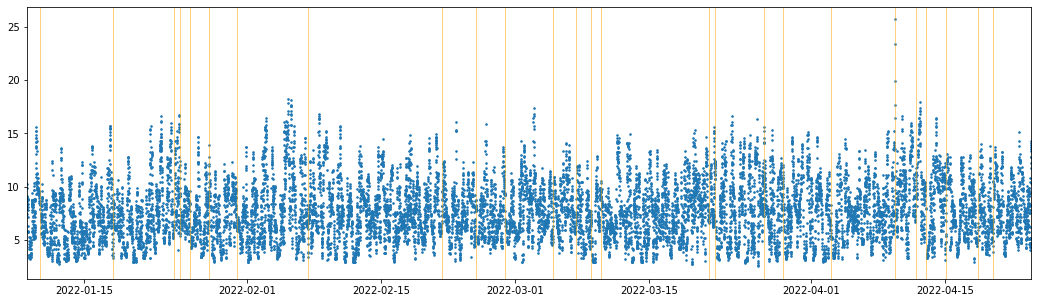

patch count: 58


In [23]:
plt.figure(figsize=(18, 5));
patch_count = scatter_patch(df_glucose, percentile_gap, start_date, end_date);
print('patch count:', patch_count)

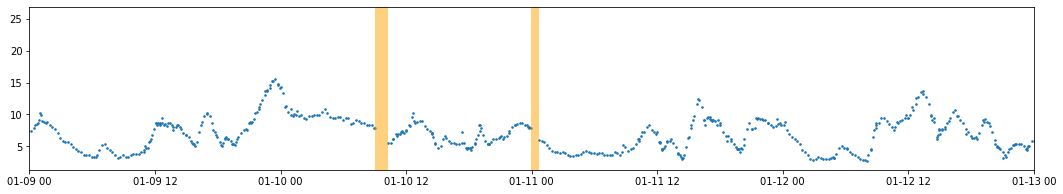

patch count: 2


In [24]:
plt.figure(figsize=(18, 3));
patch_count = scatter_patch(df_glucose, percentile_gap, start_date, pd.to_datetime('2022-01-13'));
print('patch count:', patch_count)

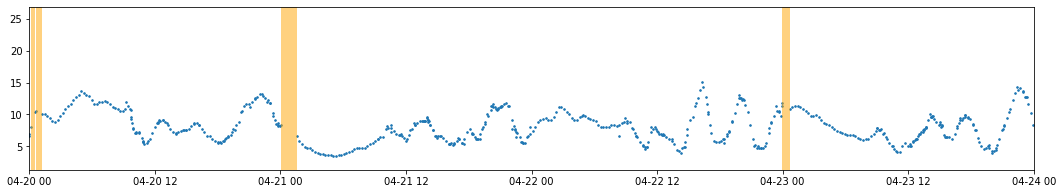

patch count: 4


In [25]:
plt.figure(figsize=(18, 3));
patch_count = scatter_patch(df_glucose, percentile_gap, pd.to_datetime('2022-04-20'), end_date);
print('patch count:', patch_count)

In [26]:
# # Get largest gaps and corresponding beginning and end timestamps
largest_gaps = time_intervals.nlargest(4)
print(largest_gaps)

dateTime
2022-02-25 02:22:00   0 days 02:52:00
2022-04-03 04:11:00   0 days 02:31:00
2022-04-18 12:05:00   0 days 02:27:00
2022-04-13 01:04:00   0 days 02:13:00
Name: dateTime, dtype: timedelta64[ns]


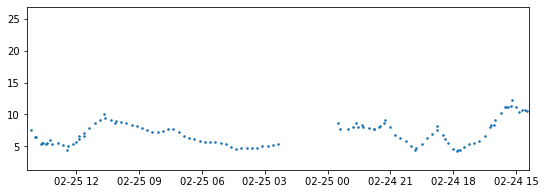

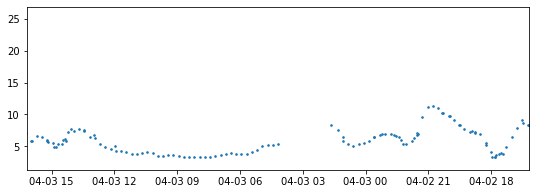

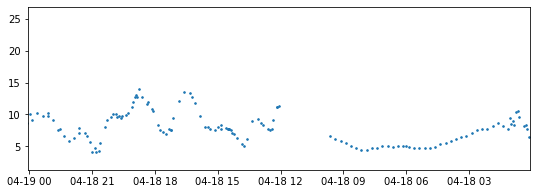

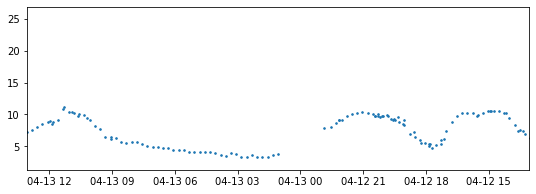

In [27]:
start = largest_gaps.index + pd.DateOffset(hours=12)
end = largest_gaps.index - pd.DateOffset(hours=12)

# TODO: FIX: why are patches not showing?
for i, gap in enumerate(largest_gaps):
    plt.figure(figsize=(9, 3));
    scatter_patch(df_glucose, percentile_gap, start[i], end[i]);

A reasonable interpolation even for the largest gaps is to draw a straight line from the last to the first data point.

#### Resample Glucose

In [37]:
# resample using 15 minute intervals, then fill in gaps using linear interpolation
df_gluc_resampled = df_glucose[['comb_gluc']].resample('15T').mean().interpolate(method='linear')
# df_gluc_resampled.index.adfreq(freq='15m')
# df_gluc_resampled.set_index(df_gluc_resampled.index).asfreq('15Min')
df_gluc_resampled.head()

,comb_gluc
dateTime,
2022-01-09 00:00:00,7.40
2022-01-09 00:15:00,7.90
2022-01-09 00:30:00,8.40
2022-01-09 00:45:00,8.85
2022-01-09 01:00:00,9.70


Check how gaps are filled

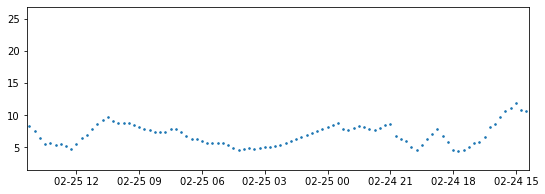

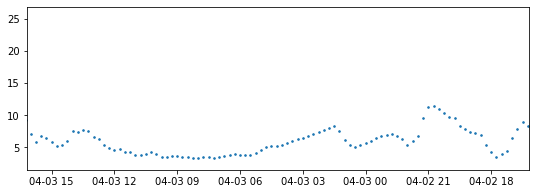

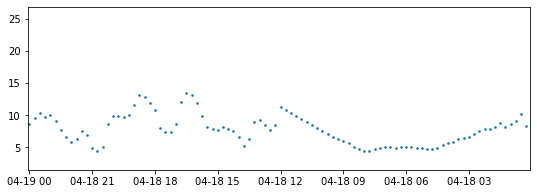

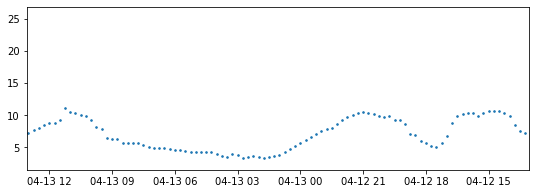

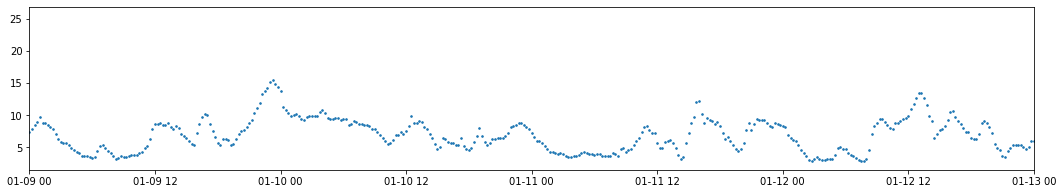

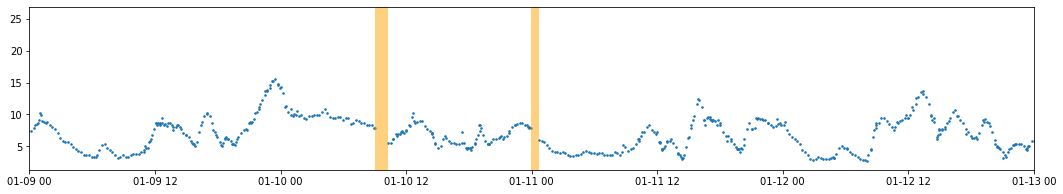

patch count: 2


In [29]:
# check how large gaps are filled in
for i, gap in enumerate(largest_gaps):
    plt.figure(figsize=(9, 3));
    scatter_patch(df_gluc_resampled, percentile_gap, start[i], end[i]);

# check how beginning is filled (no patches, since based on outdated index)
plt.figure(figsize=(18, 3));
patch_count = scatter_patch(df_gluc_resampled, percentile_gap, start_date, pd.to_datetime('2022-01-13'), patch=False);

# compare with original
plt.figure(figsize=(18, 3));
patch_count = scatter_patch(df_glucose, percentile_gap, start_date, pd.to_datetime('2022-01-13'));
print('patch count:', patch_count)

#### Check seasonality and stationarity

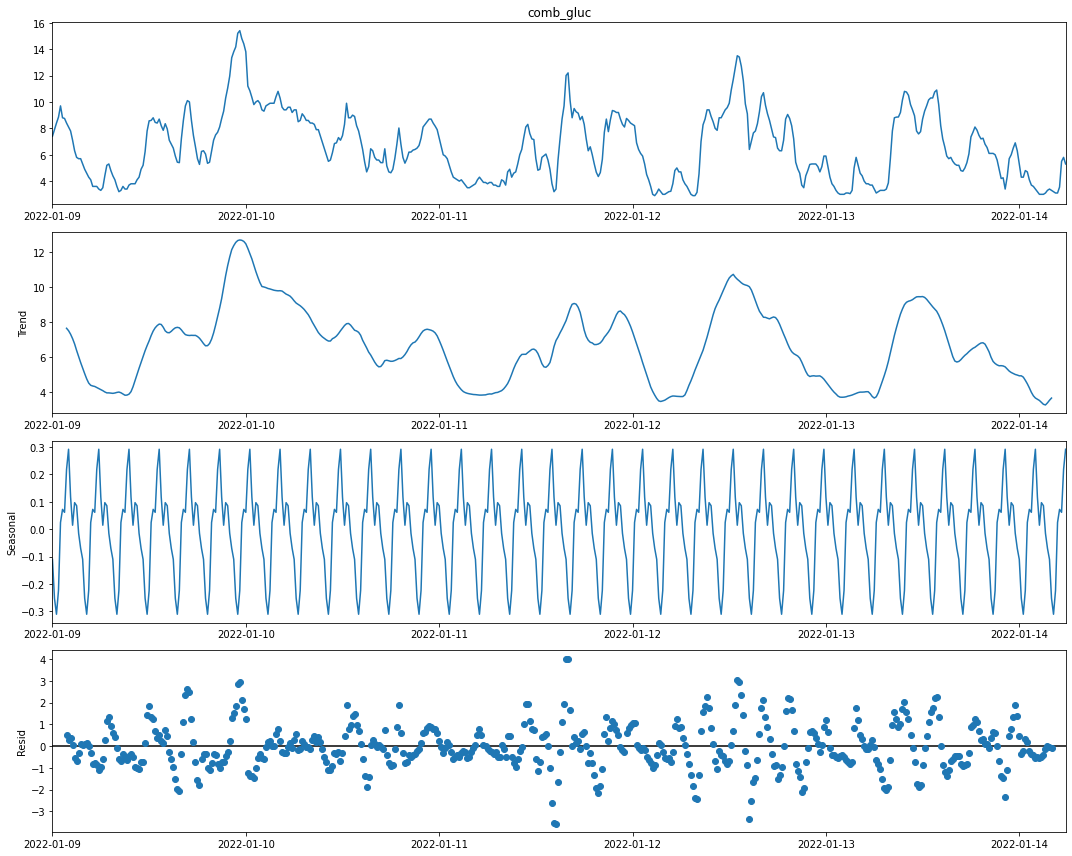

In [55]:
# check seasonality - limit time to 5 days so seasonal is not solid block
y = df_gluc_resampled.iloc[:int(df_gluc_resampled.shape[0]/20)].comb_gluc
res = seasonal_decompose(y, period=15)
# Plot the original data, the trend, the seasonality, and the residuals 
resplot = res.plot() # seasonal=False https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.DecomposeResult.plot.html#statsmodels.tsa.seasonal.DecomposeResult.plot
resplot.set_size_inches((15, 12))
resplot.tight_layout()

In [45]:
# check stationarity using Kwiatkowski–Phillips–Schmidt–Shin test (kpss)
'''
from SB time series case study: Null hypothesis of this test is that the time series data in question is stationary; if the p-value is less than the significance level (typically 0.05) then we reject the Null and infer that the data is not stationary.
'''
kpss(y)

c:\prg\mincon\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(0.7782114777105865,
 0.01,
 53,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Conclusion: data is not stationary

Some questions:
* will interpolation lead to data leakage when data is split if using a machine learning model?
* is an outlier still an outlier even if it's plausible?
* what determines lag time when creating additional features for ML models?